In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

np.set_printoptions(precision=3)

### Hyperparameter tuning

100%|██████████| 1500/1500 [02:38<00:00,  9.48it/s]


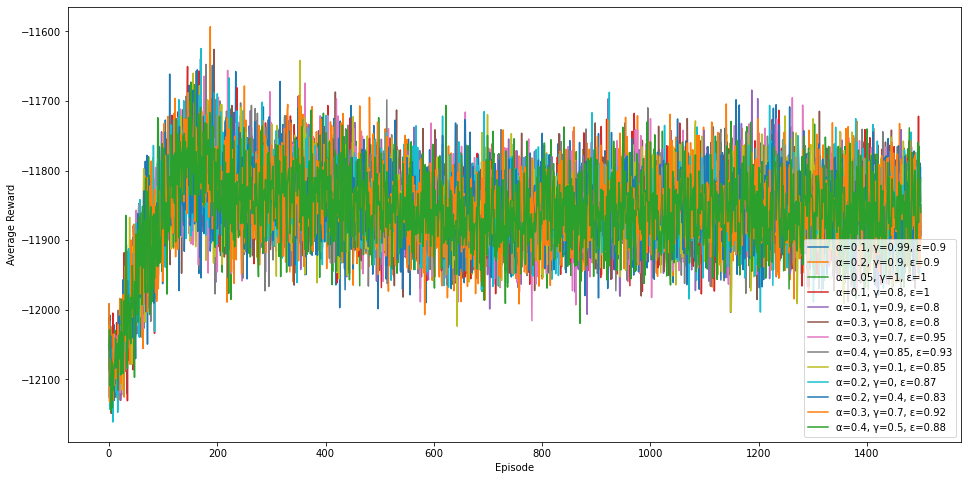

In [28]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
     
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity


class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.1, gamma=0.99, epsilon=0.8, epsilon_decay=0.995):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared))

    def act(self, state):
        discrete_state = self._discretize_state(state)
        self.epsilon = self.epsilon * self.epsilon_decay 
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

# Simulation with Q-learning
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

EPISODES = 1500
        
# Define different parameter sets
parameter_sets = [
    {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.9},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.9},
    {"alpha": 0.05, "gamma": 1, "epsilon": 1},
    {"alpha": 0.1, "gamma": 0.8, "epsilon": 1},
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.8},
    {"alpha": 0.3, "gamma": 0.8, "epsilon": 0.8},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.9},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.95},
    {"alpha": 0.4, "gamma": 0.85, "epsilon": 0.93},  
    {"alpha": 0.3, "gamma": 0.1, "epsilon": 0.85},
    {"alpha": 0.2, "gamma": 0, "epsilon": 0.87},
    {"alpha": 0.2, "gamma": 0.4, "epsilon": 0.83},
    {"alpha": 0.3, "gamma": 0.7, "epsilon": 0.92},
    {"alpha": 0.4, "gamma": 0.5, "epsilon": 0.88}
]


results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])
    rewards = []
    for episode in tqdm(range(EPISODES)):
        state = env.reset()
        env.radius = 600
#         print(state)
        done = False
        G = 0
        while not done:
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = deepcopy(next_state)
            G += reward
        rewards.append(G)

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
#     results[param_label] = avg_rewards
    results[param_label] = rewards

# Plot results
plt.figure(figsize=(16,8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

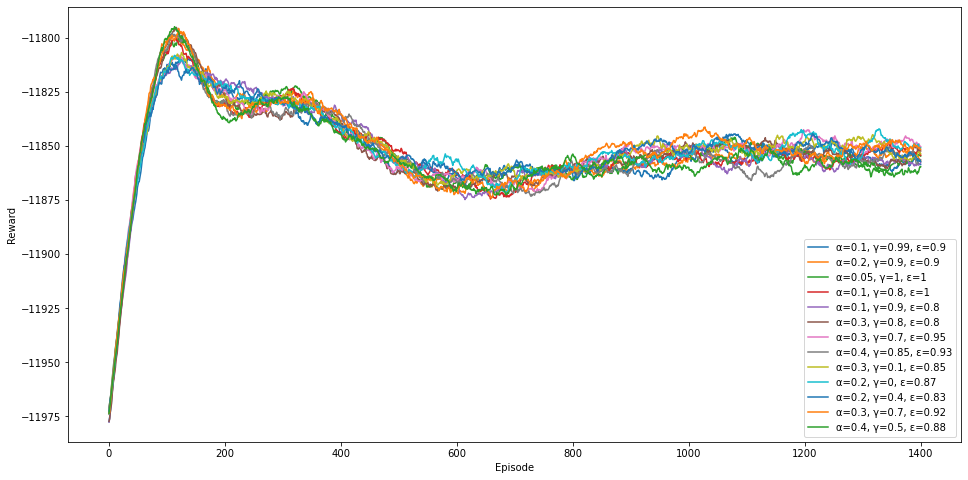

In [43]:
def moving_average(values, window_size):
    """Calculate moving average with a given window size."""
    cumsum = np.cumsum(values)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size
# Plotting smoothed rewards using moving average
WINDOW_SIZE = 100  # you can adjust this based on how smooth you want the curve

plt.figure(figsize=(16, 8))
for param_label, rewards in results.items():
    smoothed_rewards = moving_average(rewards, WINDOW_SIZE)
    plt.plot(smoothed_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

### {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.9} would generate higher average reward, we choose it as our parameter.

100%|██████████| 1000/1000 [01:49<00:00,  9.13it/s]


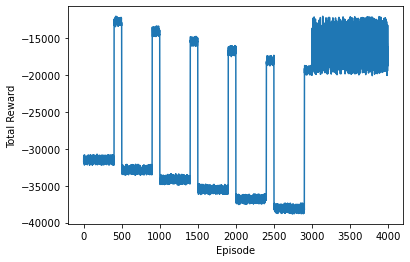

In [48]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity


class QLearningAgent:
    def __init__(self, n_actions=5, alpha=0.2, gamma=0.9, epsilon=0.9, epsilon_decay=0.995):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, int(laps_cleared))

    def act(self, state):
        discrete_state = self._discretize_state(state)
        self.epsilon = self.epsilon * self.epsilon_decay 
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)



# Simulation with Q-learning and modified strategy
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

# EPISODES = 4000
rewards = []
time_per_lap = []

radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(500)):
        # Set radius according to bin       
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
#         state[3] = np.random.randint(start_radius, end_radius)
    
        done = False
        G = 0
        local_time_per_lap = []
        while not done:
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            time_for_current_lap = (2*np.pi*env.radius/8) / velocity
            local_time_per_lap.append(time_for_current_lap)
            
            # Augmented reward condition
            if episode < 400:  # First 400 out of 500
                if done:
                    reward += 500
                elif len(local_time_per_lap) > 8:
                    if local_time_per_lap[-1] > np.mean(local_time_per_lap[-9:-1]):
                        reward -= 50
                    else:
                        reward += 20
            
            agent.update(state, action, reward, next_state)
            state = deepcopy(next_state)
            G += reward
        
        time_per_lap.append(local_time_per_lap)
        rewards.append(G)

# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        agent.update(state, action, reward, next_state)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


#### The chart above is shows that when the track is shoter the time would be less. We set it in different range to ensure we could really train our model in differetnt situation

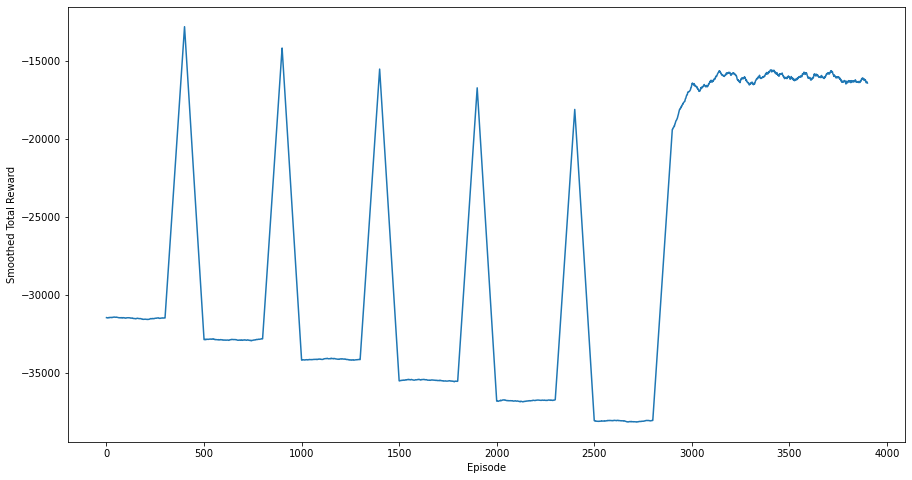

In [49]:
def moving_average(values, window_size):
    """Calculate moving average with a given window size."""
    cumsum = np.cumsum(values)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size
# Plotting smoothed rewards using moving average
WINDOW_SIZE = 100  # you can adjust this based on how smooth you want the curve
smoothed_rewards = moving_average(rewards, WINDOW_SIZE)

plt.figure(figsize=(15,8))
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.show()

## Store the q_table

In [50]:
with open('task1_q_table.pkl', 'wb') as f:
    pickle.dump(agent.q_table, f)
    
with open('task1_q_table.pkl', 'rb') as f:
    loaded_q_table = pickle.load(f)

## Import the q_table to show the training result

100%|██████████| 1000/1000 [01:23<00:00, 11.91it/s]


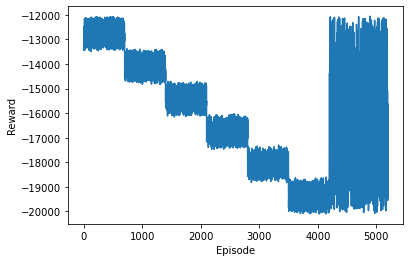

In [51]:
# Use the loaded Q-table when initializing the agent
agent = QLearningAgent(epsilon=0)
agent.q_table = loaded_q_table

# [The rest of the simulation code stays the same]
new_car = Car()
env = Track(new_car)

rewards = []
radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(700)):
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
        done = False
        G = 0
        while not done:
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            state = deepcopy(next_state)
            G += reward
        rewards.append(G)

# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

### Race 1

In [52]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 600               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -12099.20
G: -12099.01
G: -12099.17
G: -12098.56
G: -12099.19
G: -12098.41
G: -12099.90
G: -12099.23
G: -12099.37


### Race 2

In [53]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]
print(start_weather,radius)

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 700               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

80% Wet 698
G: -13452.21
G: -13452.30
G: -13450.23
G: -13451.86
G: -13452.88
G: -13453.32
G: -13451.63
G: -13452.87
G: -13452.88


### Race 3

In [54]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 800               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -14844.75
G: -14844.61
G: -14845.84
G: -14849.22
G: -14844.28
G: -14843.13
G: -14844.12
G: -14845.13
G: -14844.42


### Race 4

In [55]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 900               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -16147.82
G: -16149.18
G: -16148.96
G: -16149.41
G: -16149.37
G: -16148.82
G: -16148.37
G: -16148.65
G: -16148.95


### Race 5

In [56]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 1000               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -17439.51
G: -17439.59
G: -17439.90
G: -17440.14
G: -17439.89
G: -17439.46
G: -17440.29
G: -17439.77
G: -17440.35


### Race 6

In [57]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius =1100               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -18588.04
G: -18585.23
G: -18585.84
G: -18587.10
G: -18583.83
G: -18586.86
G: -18585.44
G: -18585.79
G: -18586.43


### Race 7

In [58]:
# Store historical weather
holder = []

state = env.reset()
start_state = deepcopy(state)
done = False
G = 0
while not done:
    holder.append(env.cur_weather)
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
    
# Initializing agents
agents = [QLearningAgent(epsilon=0) for _ in range(9)]
for a in agents:
    a.q_table = loaded_q_table

# Simulating with the same weather sequence:
start_state = env.reset()
start_weather, radius = start_state[2], start_state[3]

for agent in agents:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = 1200               # assert common track radius
    done = False
    G = 0
    i = 0
    while not done:
        env.cur_weather = holder[i]   # assert weather transition based on holder
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        i += 1
    
    print("G: %.2f" % G)

G: -19984.71
G: -19984.66
G: -19984.62
G: -19984.52
G: -19984.50
G: -19984.41
G: -19984.40
G: -19984.77
G: -19985.06


### another try of the modify the augement

100%|██████████| 1000/1000 [02:36<00:00,  6.39it/s]


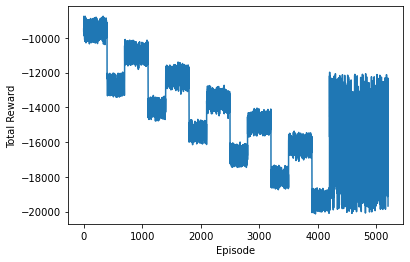

In [44]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity


class QLearningAgent:
    # modify the parameter here
    def __init__(self, n_actions=5, alpha=0.3, gamma=0.8, epsilon=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _discretize_state(self, state):
        tyre, condition, cur_weather, radius, laps_cleared = state
        return (tyre, round(condition, 2), cur_weather, radius, laps_cleared)

    def act(self, state):
        discrete_state = self._discretize_state(state)
        if discrete_state[4] >160:
            return 4
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        self.q_table[discrete_state][action] = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)


# Simulation with Q-learning and modified strategy
new_car = Car()
env = Track(new_car)

agent = QLearningAgent()

# EPISODES = 4000
rewards = []
time_per_lap = []

radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(700)):
        # Set radius according to bin       
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
        done = False
        G = 0
        local_time_per_lap = []
        while not done:
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            time_for_current_lap = (2*np.pi*env.radius) / velocity
            local_time_per_lap.append(time_for_current_lap)
            
            # Augmented reward condition
            if episode < 400:  # First 400 out of 500
                if done:
                    reward += 10000
                elif len(local_time_per_lap) > 9:
                    if local_time_per_lap[-1] > np.mean(local_time_per_lap[-10:-1]):
                        reward -= 30
                    else:
                        reward += 20
            
            agent.update(state, action, reward, next_state)
            state = deepcopy(next_state)
            G += reward
        
        time_per_lap.append(local_time_per_lap)
        rewards.append(G)

# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        agent.update(state, action, reward, next_state)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
